# Full individual differences

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf

import matplotlib.patches as mpatches


The model is the same as in the previous example, though can be
simplified since we fit the model for each participant separately.

### Simulator

In [2]:
def prior():
    alpha = np.random.beta(a=1, b=1)
    beta = np.random.beta(a=1, b=1)
    return dict(alpha=alpha, beta=beta)

def likelihood(alpha, beta, t=np.array([1, 2, 4, 7, 12, 21, 35, 59, 99])):
    theta = np.exp(-alpha*t) + beta
    theta = np.clip(theta, a_min=0, a_max=1)

    k = np.random.binomial(n=18, p=theta)
    return dict(k=k)

simulator = bf.make_simulator([prior, likelihood])


### Approximator

We will use the values of $k$ to approximate the posterior distribution
of $\alpha$ and $\beta$.

In [3]:
adapter = (
    bf.Adapter()
    .constrain(["alpha", "beta"], lower=0, upper=1)
    .concatenate(["alpha", "beta"], into="inference_variables")
    .rename("k", "inference_conditions")
    )

In [ ]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

## Training

In [ ]:
history=workflow.fit_online(epochs=10, num_batches_per_epoch=100, batch_size=256)

## Validation

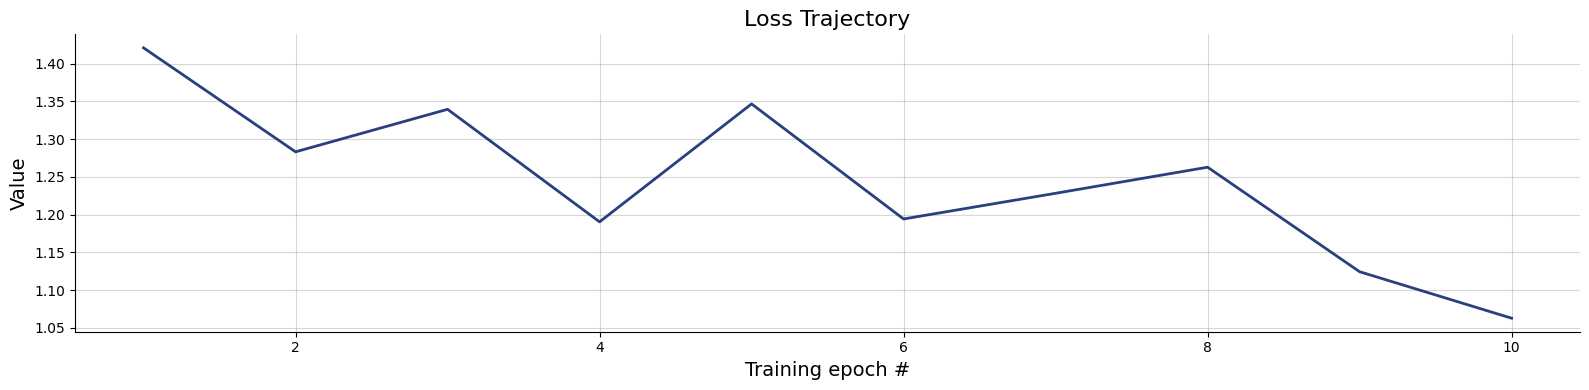

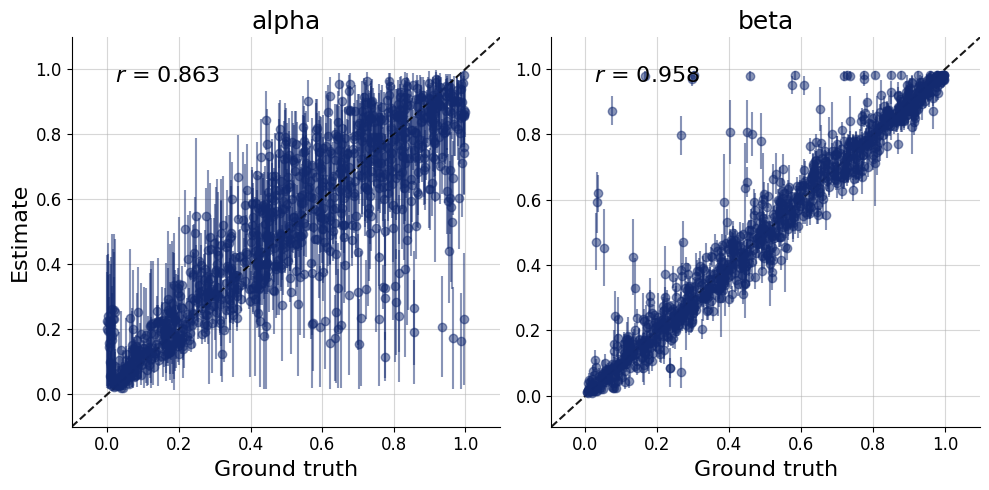

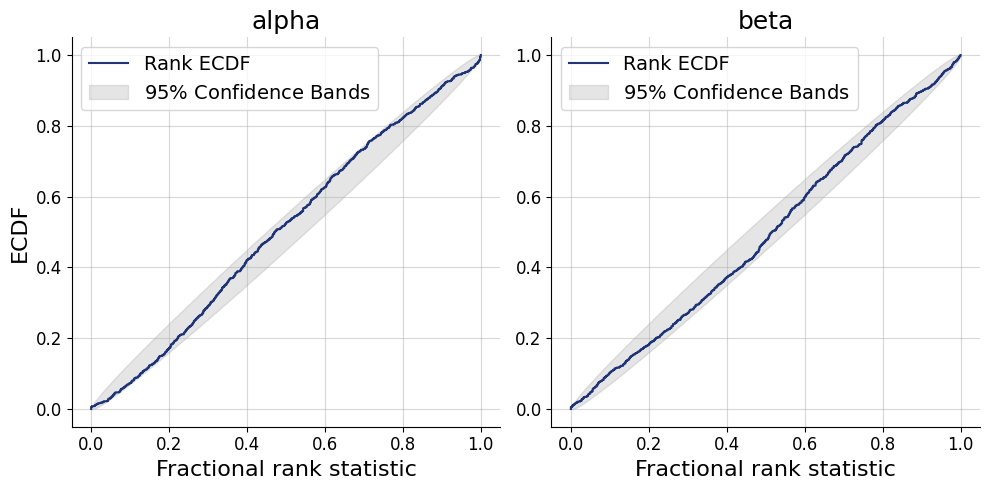

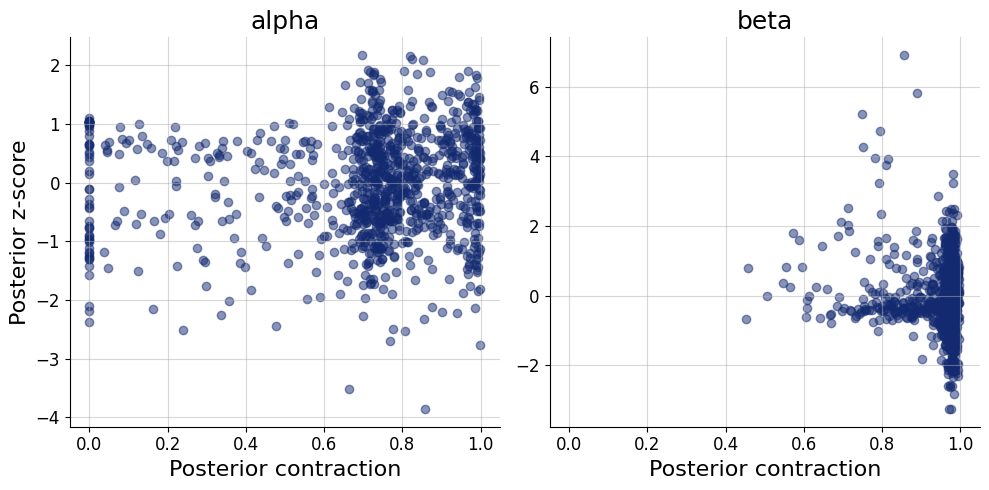

In [6]:
test_data = simulator.sample(1000)
figs = workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

## Inference

We use the data from three participants by Rubin et al. (1999) as
reported by Lee & Wagenmakers (2013). We estimate the three posteriors
simultaneously for all data sets (participants).

In [7]:
k = [[18, 18, 16, 13, 9, 6, 4, 4, 4],
     [17, 13,  9,  6, 4, 4, 4, 4, 4],
     [14, 10,  6,  4, 4, 4, 4, 4, 4]]

inference_data = dict(k=np.array(k))

In [8]:
samples=workflow.sample(num_samples=2000, conditions=inference_data)

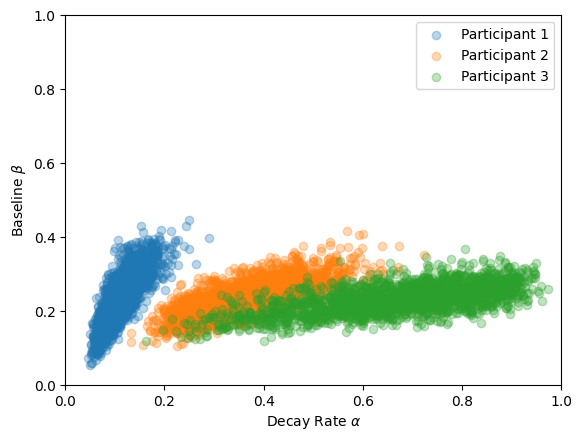

In [9]:
for i in range(3):
    plt.scatter(
        x=samples["alpha"][i,:,0], 
        y=samples["beta"][i,:,0], 
        label="Participant "+str(i+1), 
        alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Decay Rate $\\alpha$")
plt.ylabel("Baseline $\\beta$")
plt.legend()

Now we compute posterior predictives and plot them against the observed
data.

In [10]:
k_pred = np.zeros((3, 2000, 10))

for p in range(3):
    for s in range(2000):
        k_pred[p, s, :] = likelihood(
            alpha=samples["alpha"][p, s, 0],
            beta=samples["beta"][p, s, 0],
            t=np.array([1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
        )["k"]

In [11]:
# Bin the data and compute the relative frequencies for each possible count from 0 to 18.
hist = np.zeros((3, 19, 10))

for p in range(3):
    for t in range(10):
        hist[p, :, t] = np.histogram(k_pred[p, :, t], bins=19, range=[0, 19], density=True)[0]

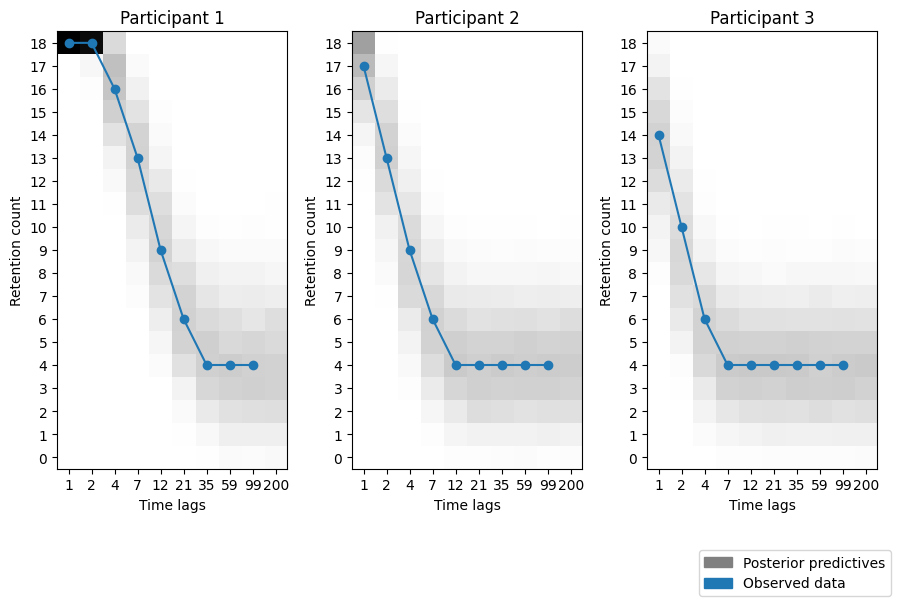

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 7))

for i, ax in enumerate(axs):
    ax.set_title("Participant " + str(i+1))
    ax.imshow(1-hist[i], 'gray', origin="lower", vmin=0, vmax=1)
    ax.set_xticks(range(10), labels=[1, 2, 4, 7, 12, 21, 35, 59, 99, 200])
    ax.set_xlabel("Time lags")
    ax.set_yticks(range(19))
    ax.set_ylabel("Retention count")
    ax.plot(range(9), inference_data["k"][i])
    ax.scatter(range(9), inference_data["k"][i])

custom_legend = [mpatches.Patch(color='gray', label='Posterior predictives'),
                 mpatches.Patch(color='#1f77b4', label='Observed data')]

fig.legend(handles=custom_legend, loc="lower right")
fig.tight_layout()

Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.

Rubin, D. C., Hinton, S., & Wenzel, A. (1999). The precise time course
of retention. *Journal of Experimental Psychology: Learning, Memory, and
Cognition*, *25*(5), 1161.